In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the Iris dataset
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
file_path = "/Users/terrylin/Desktop/2025 Winter/CS257/code/CS257/iris/iris.data"
iris = pd.read_csv(file_path, names=columns)

# Display the first few rows
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [224]:
# Convet species to numerical values
le = LabelEncoder()
iris['species'] = le.fit_transform(iris['species'])

X = iris.iloc[:, :-1].values  # Features
y = iris.iloc[:, -1].values  # Target variable
# Normalize the features
X = normalize(X, norm = 'l2')

# Split the dataset into train, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Display dataset sizes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (105, 4), Validation: (22, 4), Test: (23, 4)


In [225]:
# RFF
def feature_encoding(X,D,alpha=1):
    np.random.seed(42)

    d= X.shape[1]
    # Generate random weights
    W = np.random.normal (0,np.sqrt(alpha),(d,D))

    # Generate random hase shifts b
    b = np.random.uniform (0,2*np.pi,D)

    # Compute RFF
    Z = np.sqrt(2/D) * np.cos(np.dot(X,W) + b)

    return Z

# Feature encoding
D = 1000

X_train_rff = feature_encoding(X_train, D)
X_val_rff = feature_encoding(X_val, D)
X_test_rff = feature_encoding(X_test, D)
# Display the shape of the transformed datasets
print(f"Original shape: {X_train.shape}, RFF shape: {X_train_rff.shape}")

Original shape: (105, 4), RFF shape: (105, 1000)


In [226]:
# Initialize class hypervectors
num_classes = len(np.unique(y_train))
class_hypervectors = np.zeros((num_classes, D))

# Single-Pass fit over the training dataset
for i in range(len(X_train_rff)):
    label = y_train[i]
    class_hypervectors[label] += X_train_rff[i]


# Inference
def predict(X, class_hypervectors):
    # Compute the cosine similarity between the input and class hypervectors
    similarities = np.dot(X, class_hypervectors.T)
    # Get the index of the class with the highest similarity
    predictions = np.argmax(similarities, axis=1)
    return predictions

# Evaluate performance
def evaluate(X_train_rff,X_val_rff,X_test_rff,y_train,y_val,y_test,class_hypervectors):
    
    predictions_train = predict(X_train_rff, class_hypervectors)
    predictions_val = predict(X_val_rff, class_hypervectors)
    predictions_test = predict(X_test_rff, class_hypervectors)

    # Calculate accuracy
    accuracy_train = np.mean(predictions_train == y_train)
    accuracy_val = np.mean(predictions_val == y_val)
    accuracy_test = np.mean(predictions_test == y_test)

    print(f"Train Accuracy: {accuracy_train:.4f}")
    print(f"Validation Accuracy: {accuracy_val:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")

    return accuracy_train, accuracy_val, accuracy_test

# accuracy
accuracy_train, accuracy_val, accuracy_test = evaluate(X_train_rff, X_val_rff, X_test_rff, y_train, y_val, y_test, class_hypervectors)


Train Accuracy: 0.6095
Validation Accuracy: 0.3636
Test Accuracy: 0.6522


In [227]:
# Perform iterative learning over the dataset
def iterative_learning(X_train_rff, y_train, class_hypervectors, num_iterations=10,learning_rate=0.1):
    num_classes = len(np.unique(y_train))

    for epoch in range(num_iterations):
        num_misclassified = 0

        for i in range(len(X_train_rff)):
            sample_rff = X_train_rff[i]
            label = y_train[i]
            # Compute similarities
            similarities = np.dot(sample_rff, class_hypervectors.T)

            # Get the predicted class
            predicted_class = np.argmax(similarities)
            # Check if the sample is misclassified
            if predicted_class != label:
                num_misclassified += 1
                # Update the class hypervector
                class_hypervectors[label] += sample_rff * learning_rate
                class_hypervectors[predicted_class] -= sample_rff * learning_rate
                
        # Print the number of misclassified samples
        print(f"Epoch {epoch+1}/{num_iterations}, Misclassified samples: {num_misclassified}")
    return class_hypervectors
# Perform iterative learning
class_hypervectors = iterative_learning(X_train_rff, y_train, class_hypervectors, num_iterations=10,learning_rate=0.1)
# Evaluate performance after iterative learning
accuracy_train, accuracy_val, accuracy_test = evaluate(X_train_rff, X_val_rff, X_test_rff, y_train, y_val, y_test, class_hypervectors)

Epoch 1/10, Misclassified samples: 40
Epoch 2/10, Misclassified samples: 12
Epoch 3/10, Misclassified samples: 14
Epoch 4/10, Misclassified samples: 10
Epoch 5/10, Misclassified samples: 10
Epoch 6/10, Misclassified samples: 10
Epoch 7/10, Misclassified samples: 10
Epoch 8/10, Misclassified samples: 10
Epoch 9/10, Misclassified samples: 10
Epoch 10/10, Misclassified samples: 8
Train Accuracy: 0.9619
Validation Accuracy: 1.0000
Test Accuracy: 0.9565


In [228]:
# Early Stopping 
def iterative_learning_earlystop(X_train_rff, y_train, X_val_rff, y_val, X_test_rff, y_test, class_hypervectors, num_epochs=50, patience=5):
    num_classes = len(np.unique(y_train))
    best_val_accuracy = 0
    best_class_hypervectors = class_hypervectors.copy()
    patience_count = 0

    all_accuracies = {"train:": [], "val": [], "test": []}

    for epoch in range(100):  # Arbitrary large number of epochs
        num_misclassified = 0

        for i in range(len(X_train_rff)):
            sample_rff = X_train_rff[i]
            label = y_train[i]
            # Compute similarities
            similarities = np.dot(sample_rff, class_hypervectors.T)
            # Get the predicted class
            predicted_class = np.argmax(similarities)
            # Check if the sample is misclassified
            if predicted_class != label:
                num_misclassified += 1
                # Update the class hypervector
                class_hypervectors[label] += sample_rff
                class_hypervectors[predicted_class] -= sample_rff
                
        # Evaluate on validation set
        train_accuracy = np.mean(predict(X_train_rff, class_hypervectors) == y_train)
        val_accuracy = np.mean(predict(X_val_rff, class_hypervectors) == y_val)
        test_accuracy = np.mean(predict(X_test_rff, class_hypervectors) == y_test)
        print(f"Epoch {epoch+1}, Misclassified samples: {num_misclassified}, Validation Accuracy: {val_accuracy:.4f}")

        all_accuracies["train:"].append(train_accuracy)
        all_accuracies["val"].append(val_accuracy)
        all_accuracies["test"].append(test_accuracy)

    
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_class_hypervectors = class_hypervectors.copy()
            patience_count = 0
        else:
            patience_count += 1

        # Early stopping condition
        if patience_count >= patience:
            print(f"Early stopping at epoch {epoch+1}.")
            break

    return best_class_hypervectors, all_accuracies
# Perform iterative learning with early stopping
best_class_hypervectors, all_accuracies = iterative_learning_earlystop(
    X_train_rff, y_train, X_val_rff, y_val, X_test_rff, y_test, class_hypervectors,num_epochs=100, patience=5)


Epoch 1, Misclassified samples: 21, Validation Accuracy: 0.8636
Epoch 2, Misclassified samples: 48, Validation Accuracy: 0.8636
Epoch 3, Misclassified samples: 34, Validation Accuracy: 1.0000
Epoch 4, Misclassified samples: 8, Validation Accuracy: 1.0000
Epoch 5, Misclassified samples: 8, Validation Accuracy: 1.0000
Epoch 6, Misclassified samples: 8, Validation Accuracy: 1.0000
Epoch 7, Misclassified samples: 8, Validation Accuracy: 1.0000
Epoch 8, Misclassified samples: 8, Validation Accuracy: 1.0000
Early stopping at epoch 8.


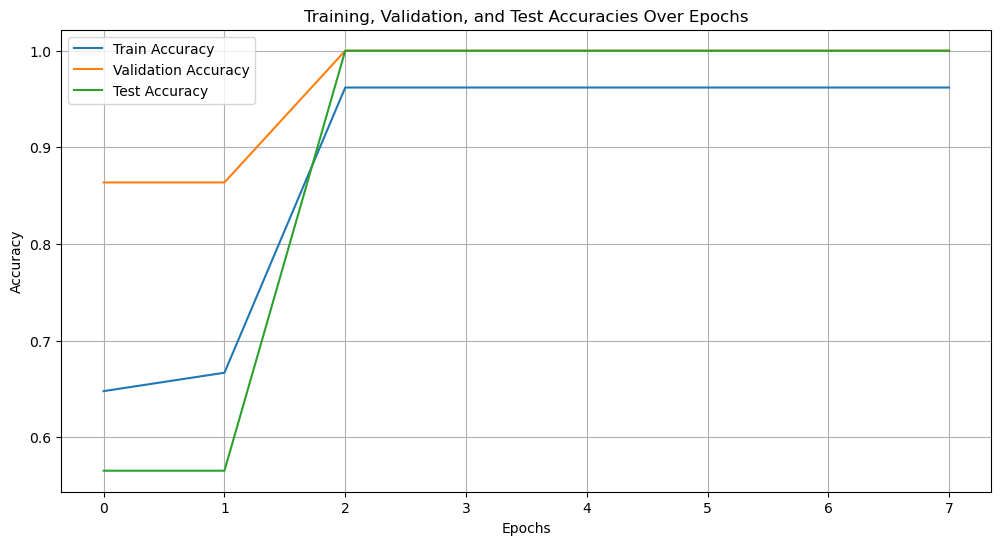

In [229]:
# Plotting the accuracies
plt.figure(figsize=(12, 6))
plt.plot(all_accuracies["train:"], label='Train Accuracy')
plt.plot(all_accuracies["val"], label='Validation Accuracy')
plt.plot(all_accuracies["test"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracies Over Epochs')
plt.legend()
plt.grid()
plt.show()
